Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training Epoch 1/7:   0%|                                                                     | 0/3712 [00:00<?, ?it/s]C:\Python\Lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Validating: 100%|████████████████████████████████████████████████████████████████████| 928/928 [03:17<00:00,  4.70it/s]


Epoch 1, Train Loss: 1.8529, Validation Loss: 1.2336, Validation F1: 0.4677


Validating: 100%|████████████████████████████████████████████████████████████████████| 928/928 [03:06<00:00,  4.97it/s]


Epoch 2, Train Loss: 0.9040, Validation Loss: 1.0430, Validation F1: 0.5650


Validating: 100%|████████████████████████████████████████████████████████████████████| 928/928 [03:01<00:00,  5.12it/s]


Epoch 3, Train Loss: 0.5574, Validation Loss: 0.9264, Validation F1: 0.6217


Validating: 100%|████████████████████████████████████████████████████████████████████| 928/928 [03:07<00:00,  4.96it/s]


Epoch 4, Train Loss: 0.3789, Validation Loss: 0.9408, Validation F1: 0.6623


Validating: 100%|████████████████████████████████████████████████████████████████████| 928/928 [03:06<00:00,  4.97it/s]


Epoch 5, Train Loss: 0.2649, Validation Loss: 0.9742, Validation F1: 0.6832


Validating: 100%|████████████████████████████████████████████████████████████████████| 928/928 [03:06<00:00,  4.96it/s]


Epoch 6, Train Loss: 0.1887, Validation Loss: 1.0291, Validation F1: 0.6904


Validating: 100%|████████████████████████████████████████████████████████████████████| 928/928 [03:06<00:00,  4.97it/s]


Epoch 7, Train Loss: 0.1612, Validation Loss: 1.0291, Validation F1: 0.6904


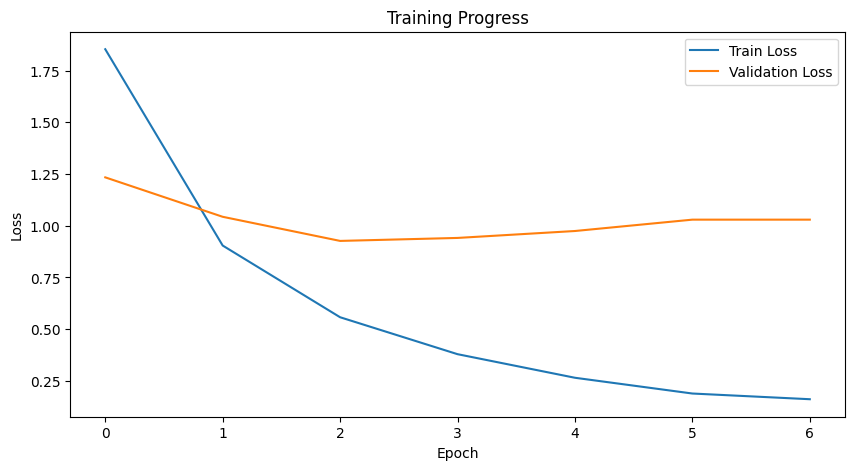

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, AdamW, get_linear_schedule_with_warmup
from torch.nn.utils.rnn import pad_sequence
import json
from torch.cuda.amp import autocast, GradScaler
import logging
import os
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import torch.nn.functional as F
import warnings

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Load data from JSON file with nested structure
def load_data_from_nested_json(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)

    questions = []
    contexts = []
    answers = []

    for item in data["data"]:
        for paragraph in item["paragraphs"]:
            context = paragraph["context"]
            for qa in paragraph["qas"]:
                question = qa["question"]
                answer = qa["answers"][0]["text"]
                questions.append(question)
                contexts.append(context)
                answers.append(answer)

    return questions, contexts, answers

# Data augmentation function
def augment_data(questions, contexts, answers):
    augmented_questions = []
    augmented_contexts = []
    augmented_answers = []

    for question, context, answer in zip(questions, contexts, answers):
        # Original data
        augmented_questions.append(question)
        augmented_contexts.append(context)
        augmented_answers.append(answer)
        
        # Add question variation
        augmented_questions.append(f"Can you tell me {question.lower()}?")
        augmented_contexts.append(context) 
        augmented_answers.append(answer)

    return augmented_questions, augmented_contexts, augmented_answers

# Dataset class with doc stride implementation
class SpokenSQuADDataset(Dataset):
    def __init__(self, questions, contexts, answers, tokenizer, max_length=512, doc_stride=128):
        self.questions = questions
        self.contexts = contexts
        self.answers = answers
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.doc_stride = doc_stride

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        question = self.questions[idx]
        context = self.contexts[idx]
        answer_text = self.answers[idx]

        # Tokenize question and context
        tokenized_example = self.tokenizer(
            question,
            context,
            max_length=self.max_length,
            truncation='only_second',
            stride=self.doc_stride,
            return_overflowing_tokens=True,
            return_offsets_mapping=True,
            padding='max_length',
            return_tensors='pt'
        )

        offsets = tokenized_example.offset_mapping[0]

        start_char = context.find(answer_text)
        end_char = start_char + len(answer_text)

        start_position = None
        end_position = None
        for i, (offset_start, offset_end) in enumerate(offsets):
            if offset_start <= start_char < offset_end:
                start_position = i
            if offset_start < end_char <= offset_end:
                end_position = i
                break

        if start_position is None or end_position is None:
            start_position = 0
            end_position = 0

        if start_position > end_position:
            start_position, end_position = end_position, start_position

        start_position = min(start_position, self.max_length - 1)
        end_position = min(end_position, self.max_length - 1)

        return {
            'input_ids': tokenized_example.input_ids[0],
            'attention_mask': tokenized_example.attention_mask[0],
            'start_positions': torch.tensor([start_position], dtype=torch.long),
            'end_positions': torch.tensor([end_position], dtype=torch.long)
        }

# Custom collate function for padding
def collate_fn(batch):
    max_len = max([item['input_ids'].size(0) for item in batch])
    
    all_input_ids = []
    all_attention_masks = []
    all_start_positions = []
    all_end_positions = []

    for item in batch:
        input_ids = item['input_ids']
        attention_mask = item['attention_mask']
        start_positions = item['start_positions']
        end_positions = item['end_positions']

        padding_length = max_len - input_ids.size(0)
        input_ids = F.pad(input_ids, (0, padding_length), value=0)
        attention_mask = F.pad(attention_mask, (0, padding_length), value=0)

        all_input_ids.append(input_ids)
        all_attention_masks.append(attention_mask)
        all_start_positions.append(start_positions)
        all_end_positions.append(end_positions)

    return {
        'input_ids': torch.stack(all_input_ids),
        'attention_mask': torch.stack(all_attention_masks),
        'start_positions': torch.cat(all_start_positions),
        'end_positions': torch.cat(all_end_positions)
    }

# Validation function
def validate(model, val_dataloader, device):
    model.eval()
    total_val_loss = 0
    val_f1_scores = []

    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc="Validating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)

            with autocast():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    start_positions=start_positions,
                    end_positions=end_positions
                )
                loss = outputs.loss
                total_val_loss += loss.item()

            start_preds = torch.argmax(outputs.start_logits, dim=-1)
            end_preds = torch.argmax(outputs.end_logits, dim=-1)

            # Calculate F1 score for validation
            f1 = f1_score(start_positions.cpu(), start_preds.cpu(), average="macro")
            val_f1_scores.append(f1)

    avg_val_loss = total_val_loss / len(val_dataloader)
    avg_val_f1 = sum(val_f1_scores) / len(val_f1_scores)

    return avg_val_loss, avg_val_f1

# Training function
def train(model, train_dataloader, val_dataloader, optimizer, scheduler, device, num_epochs, accumulation_steps):
    scaler = GradScaler()
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch_idx, batch in enumerate(tqdm(train_dataloader, desc=f'Training Epoch {epoch + 1}/{num_epochs}')):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)

            with autocast():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    start_positions=start_positions,
                    end_positions=end_positions
                )
                loss = outputs.loss / accumulation_steps

            scaler.scale(loss).backward()

            if (batch_idx + 1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                scheduler.step()

            total_loss += loss.item() * accumulation_steps

        avg_train_loss = total_loss / len(train_dataloader)
        val_loss, val_f1 = validate(model, val_dataloader, device)

        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)

        log_message = f'Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation F1: {val_f1:.4f}'
        print(log_message)
        logger.info(log_message)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'best_model.pth')

    # Visualize training progress
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Progress')
    plt.legend()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Load data
    questions, contexts, answers = load_data_from_nested_json('Spoken-SQuAD/spoken_train-v1.1.json')
    augmented_questions, augmented_contexts, augmented_answers = augment_data(questions, contexts, answers)

    # Tokenizer
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

    # Create dataset and dataloaders
    dataset = SpokenSQuADDataset(augmented_questions, augmented_contexts, augmented_answers, tokenizer)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    
    train_dataloader = DataLoader(train_dataset, batch_size=16, collate_fn=collate_fn)
    val_dataloader = DataLoader(val_dataset, batch_size=16, collate_fn=collate_fn)

    # Define model
    model = AutoModelForQuestionAnswering.from_pretrained('bert-base-uncased').to('cuda')
    optimizer = AdamW(model.parameters(), lr=5e-5)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * 3)

    # Train the model
    train(model, train_dataloader, val_dataloader, optimizer, scheduler, device='cuda', num_epochs=7, accumulation_steps=2)


In [4]:
# Load test data
test_questions, test_contexts, test_answers = load_data_from_nested_json('Spoken-SQuAD/spoken_test-v1.1.json')

# Ensure test_answers are properly formatted (strip extra characters)
test_answers = [answer[0] if isinstance(answer, tuple) else answer for answer in test_answers]

# Create test dataset and dataloader
test_dataset = SpokenSQuADDataset(test_questions, test_contexts, test_answers, tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=16, collate_fn=collate_fn)

# Evaluation function for test set
def evaluate_on_test_set(model, test_dataloader, device):
    model.eval()
    test_f1_scores = []

    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Evaluating on Test Set"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)

            with autocast():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )

            start_preds = torch.argmax(outputs.start_logits, dim=-1)
            end_preds = torch.argmax(outputs.end_logits, dim=-1)

            # Calculate F1 score for each prediction
            for true_start, true_end, pred_start, pred_end in zip(start_positions, end_positions, start_preds, end_preds):
                f1 = f1_score(
                    [true_start.item(), true_end.item()],
                    [pred_start.item(), pred_end.item()],
                    average="macro"
                )
                test_f1_scores.append(f1)

    avg_test_f1 = sum(test_f1_scores) / len(test_f1_scores)
    return avg_test_f1

# Load the trained model for evaluation
model.load_state_dict(torch.load('best_model.pth'))
avg_test_f1 = evaluate_on_test_set(model, test_dataloader, device='cuda')

# Print F1 score and compare with baseline
print(f"Average Test F1 Score: {avg_test_f1:.2f}")

C:\Users\smahm\AppData\Local\Temp\ipykernel_26300\632426665.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))
Evaluati

Average Test F1 Score: 0.50
